# **Implementation of Autoencoder for anomaly detection**

In [1]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

Tensorflow version 2.3.1


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
loc1= '../input/cloud-anomaly-detection-images/cloud/cloud'
loc2="../input/cloud-anomaly-detection-images/noncloud/noncloud"

In [3]:
#Loading and Preprocessed all the non-cloud satellite images for training
T_ds = []
from tqdm import tqdm
img_list = os.listdir(loc2)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(loc2+'/'+str(i), target_size=(384,384,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    #normalizing target
    img = img/255
    T_ds.append(img)
    
T_ds = np.array(T_ds)

100%|██████████| 1500/1500 [00:11<00:00, 131.52it/s]


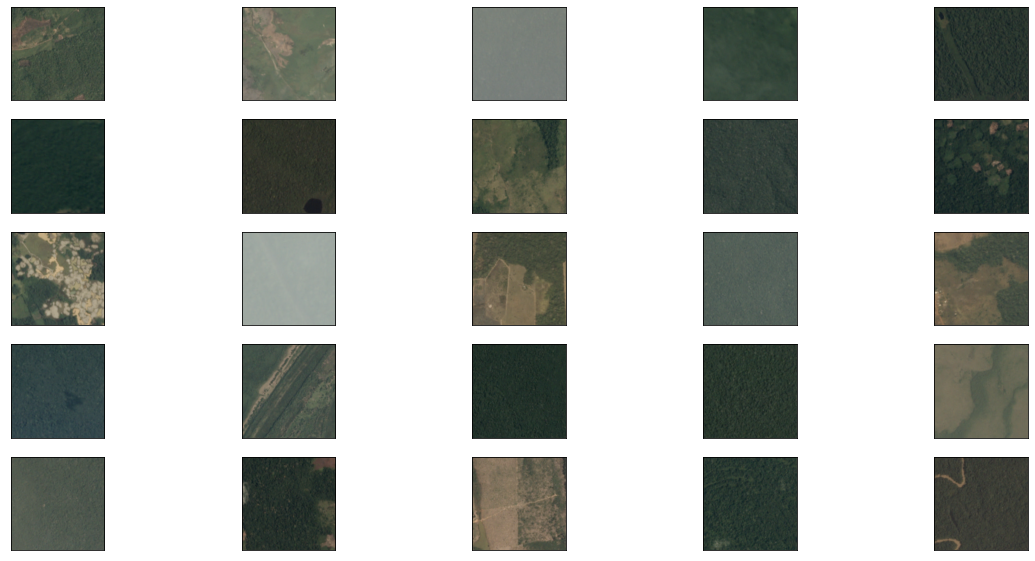

In [7]:
#viewing 25 n_cloud images
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(T_ds[i])
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    plt.grid(False)
plt.show()

# Augmenting Non-cloud Images

In [4]:
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)


def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  
    warp_image = warp(image, transform, mode="wrap")
    return warp_image




In [5]:
aug_images=[]
for i in T_ds:
    img = add_noise(i)
    img = blur_image(img)
    img = warp_shift(img)
    aug_images.append(img)
aug_images = np.array(aug_images)

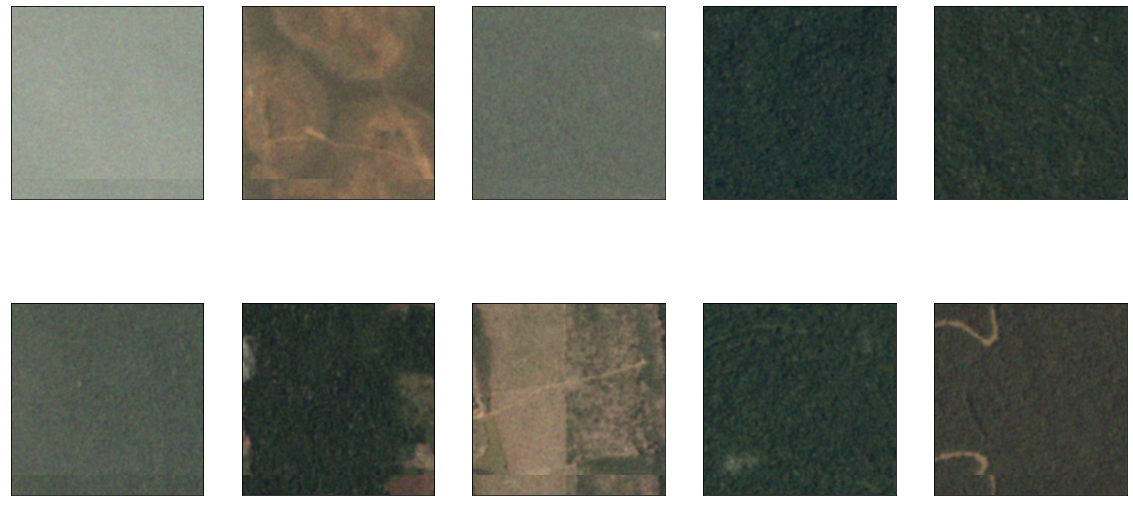

In [6]:
#Showing Augmented non-cloud images
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(aug_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(aug_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [7]:
#Configuring hyperparameters
IMAGE_SIZE = [384,384]
SEED = 42
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 64 
n_hidden_4 = 16
n_hidden_5 = 8
convkernel = (3, 3)  
poolkernel = (2, 2) 

In [8]:
#seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

# using TPU framework for boosting Learning process

In [9]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Using Autoencoder architecture For Image Transformation

In [11]:
def get_model():
    K.clear_session()
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3))

        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(inp1)
        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        encoded = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)


        #decoder
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=1, activation='relu', padding='same')(x)

        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)

        model = tf.keras.models.Model(inputs = inp1, outputs = decoded)

        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

# Using Pretrained VGG19 for Encoder and Transposed convolution for Decoder

In [12]:
def get_vgg19():
    K.clear_session()
    with strategy.scope():
        image_input = tf.keras.layers.Input(shape = (*IMAGE_SIZE,3))
        vg19 = tf.keras.applications.VGG19(input_tensor = image_input, weights = 'imagenet', include_top=False)
        encoded = vg19.get_layer('block5_pool').output
        #decode
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=2, activation='relu', padding='same')(x)
        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)
        model = tf.keras.models.Model(inputs = image_input, outputs = decoded)
        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )
        return model

In [17]:

model=  get_vgg19() #get_model()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
_______________________________________________________

In [13]:
#Splitting the dataset into train and test with ratio of 80:20.
X_train, X_test = train_test_split(T_ds, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape)


(1200, 384, 384, 3) (300, 384, 384, 3)


In [14]:
del T_ds;  gc.collect()

79

In [15]:
#model training 
#configuring required parameters
EPOCHS = 100
BATCH_SIZE = 16
NUM_TRAINING_IMAGES = X_train.shape[0]
steps = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_VALID_IMAGES = X_test.shape[0]
val_steps = NUM_VALID_IMAGES // BATCH_SIZE

In [18]:
#Model training
sav = tf.keras.callbacks.ModelCheckpoint(
    
    'Enc'+'.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# lr scheduler
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001)
model.fit(X_train, X_train,
      validation_data=(X_test, X_test),
      steps_per_epoch=steps,
      validation_steps=val_steps,
      epochs = EPOCHS,
      callbacks= [sav, cb_lr_schedule,early_stopping],
      verbose = 1)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 00001: val_loss improved from inf to 0.00384, saving model to Enc.h5
75/75 [==============================] - 33s 440ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0552
Epoch 00002: val_loss improved from 0.00384 to 0.00222, saving model to Enc.h5
75/75 [==============================] - 10s 132ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 00003: val_loss improved from 0.00222 to 0.00190, saving model to Enc.h5
75/75 [==============================] - 10s 132ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_lo


Epoch 00023: ReduceLROnPlateau reducing learning rate to 7.680000271648168e-06.
75/75 [==============================] - 10s 131ms/step - loss: 6.8170e-04 - root_mean_squared_error: 0.0261 - val_loss: 6.5794e-04 - val_root_mean_squared_error: 0.0257
Epoch 24/100
75/75 [==============================] - ETA: 0s - loss: 6.7165e-04 - root_mean_squared_error: 0.0259
Epoch 00024: val_loss improved from 0.00066 to 0.00065, saving model to Enc.h5
75/75 [==============================] - 10s 132ms/step - loss: 6.7165e-04 - root_mean_squared_error: 0.0259 - val_loss: 6.4724e-04 - val_root_mean_squared_error: 0.0254
Epoch 25/100
75/75 [==============================] - ETA: 0s - loss: 6.6694e-04 - root_mean_squared_error: 0.0258
Epoch 00025: val_loss improved from 0.00065 to 0.00064, saving model to Enc.h5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.0720002541784197e-06.
75/75 [==============================] - 10s 131ms/step - loss: 6.6694e-04 - root_mean_squared_error: 0.0258 

# Let's read Cloud images

In [21]:
cld_images=[]
import os
img_list = os.listdir(loc1)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(loc1+'/'+str(i), target_size=(384,384,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    cld_images.append(img)
    
cld_images= np.array(cld_images)
cld_images.shape

100%|██████████| 100/100 [00:00<00:00, 159.85it/s]


(100, 384, 384, 3)

# Visualizing Cld_images

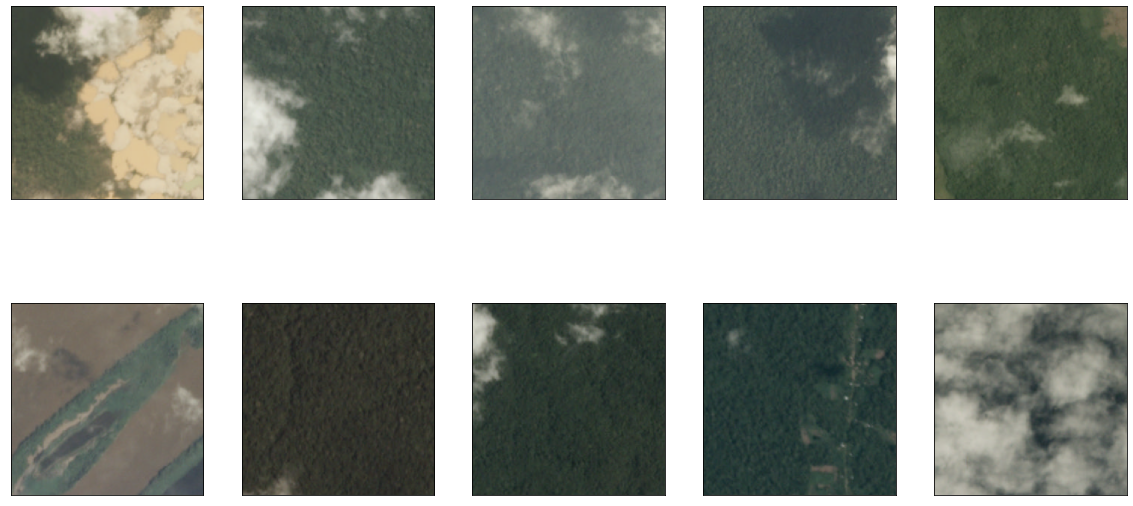

In [22]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(cld_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(cld_images[i+30])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
#testing the model
test_predictions =  model.predict(np.concatenate((X_test[:100], cld_images), axis=0))

In [24]:
pred = []
for i in (tf.keras.losses.mean_squared_error(np.concatenate((X_test[:100], cld_images), axis=0), test_predictions)).numpy():
    pred.append(tf.math.reduce_mean(i).numpy())

In [25]:
y_cap=[]
threshold=0.001
for i in pred:
    if i> threshold:
        y_cap.append(1)
    else:
        y_cap.append(0)

In [26]:
pd.value_counts(y_cap)

0    144
1     56
dtype: int64

In [27]:
actual = [0 for i in range(0,len(X_test[:100]))]+[1 for i in range(0,len(cld_images))]

In [28]:
score = pd.DataFrame()
score['matrix'] = ['F1_score','Recall','Precision']
score['Values'] = [(f1_score(actual,y_cap)),(recall_score(actual,y_cap)),(precision_score(actual,y_cap))]

In [29]:
score

,matrix,Values
0,F1_score,0.500000
1,Recall,0.390000
2,Precision,0.696429


In [30]:
pred

[0.00058710366,
 0.0010315457,
 0.00012081784,
 0.0004494735,
 0.00068009883,
 0.00072093226,
 0.0005126341,
 0.0003128302,
 0.00029086642,
 0.00097609474,
 0.0010346349,
 0.002467083,
 0.0005012603,
 0.00075446465,
 0.0007473752,
 0.00038433433,
 0.00024918813,
 0.00023452369,
 9.65172e-05,
 0.0006568251,
 0.0002945758,
 0.000315304,
 0.0014636551,
 0.0009509611,
 0.0004311301,
 0.009070952,
 0.00042449858,
 0.00020287385,
 0.0005624165,
 0.00038574642,
 0.00032755686,
 0.00027265766,
 0.00038484417,
 0.00044683687,
 0.0011126623,
 0.00048790826,
 0.00022367683,
 0.00013744434,
 0.00046276208,
 0.0011824779,
 0.0013180556,
 0.0005903185,
 0.00091231905,
 0.0009094599,
 0.00011645941,
 0.00022854247,
 0.0005368603,
 0.00035839598,
 0.0002332057,
 0.0009960112,
 0.00037830183,
 0.0005301345,
 0.0043067504,
 0.0025186953,
 0.0003851229,
 0.00041989403,
 0.0004716884,
 0.0005322493,
 9.044256e-05,
 0.0003963928,
 0.0006253946,
 0.00031172292,
 0.00019504671,
 0.0005275815,
 0.0008025302,


# Visualizing Result with Confusion Matrix

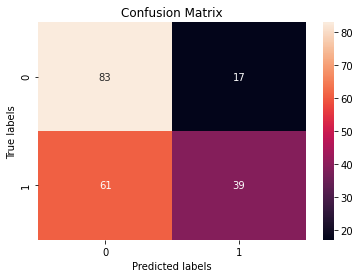

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, y_cap)
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 